# SVM skin classifier
- based on skin RGB pixels
- using [UCI skin non-skin dataset](https://archive.ics.uci.edu/ml/datasets/skin+segmentation)
-  50859 pixels are the skin samples and 194198 are non-skin samples

In [6]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import f1_score

import tqdm
import pickle
from joblib import dump, load

#### Read UCI skin RGB pixel data

In [ ]:
data = pd.read_csv('../dataset/uci2012/Skin_NonSkin.txt',header=None,sep='\t')
data.columns = ['R','G','B','label']
data['label'] = data['label'].replace(2,0)

In [ ]:
data.head()

In [ ]:
data['label'].value_counts()

### build SVM

In [ ]:
X = data[['R','G','B']].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

In [ ]:
svm = SVC(gamma='scale')
#svm.fit(np.r_[X_train_YR,X_val_YR],np.r_[y_train_YR,y_val_YR])
svm.fit(X_train,y_train)

In [ ]:
y_pred = svm.predict(X_test)

In [ ]:
f1_score(y_pred,y_test,average='weighted')

### Save model, load model

In [ ]:
dump(svm, 'svm.joblib') 

In [8]:
#svm = load('svm.joblib') 

## Eval on FSD testing dataset

In [1]:
import cv2
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from PIL import Image
import os.path as osp
from utils import intersect_and_union
import seaborn as sns

#sns.set_style("whitegrid")
rc={'axes.labelsize': 14, 'font.size': 12, 'legend.fontsize': 12, 'axes.titlesize': 16}
plt.rcParams.update(**rc)
plt.rcParams['figure.figsize'] = 8, 6

palette = [[129, 127, 38],[249, 220, 212]]

### View sample

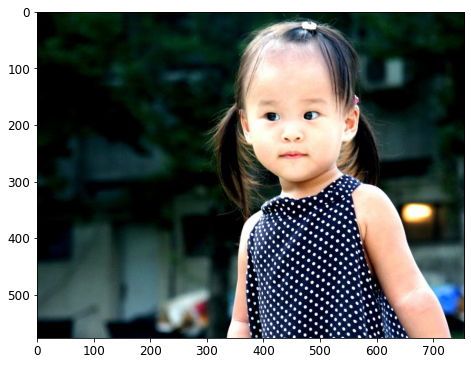

In [2]:
# Resize image to a width of 250
img = Image.open('../dataset/fsd4000/Original/im02000.jpg') 
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.show()

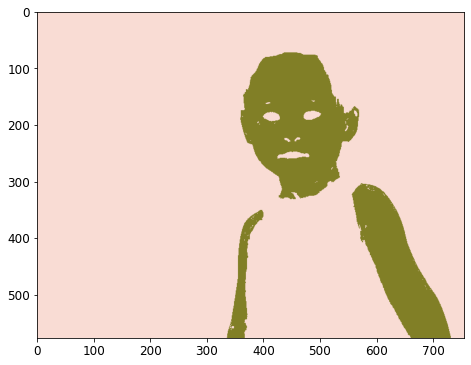

In [4]:
label = Image.open('../dataset/fsd4000/Skin/im02000.png')
plt.figure(figsize=(8, 6))
plt.imshow(label)
plt.show()

### View sample extracted using SVM

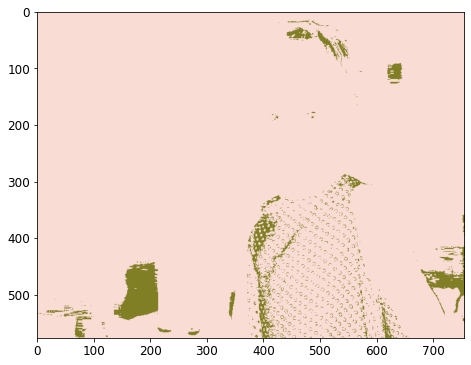

In [20]:
image = np.array(Image.open('../dataset/fsd4000/Original/im02000.jpg'))
pred_label = svm.predict(image.reshape(-1,3))
pred_label = pred_label.reshape(image.shape[0:2]).astype(np.uint8)
pred_label  = np.where(pred_label==1,0,1).astype(np.uint8) 

pred_label_seg  = Image.fromarray(pred_label).convert('P')
pred_label_seg.putpalette(np.array(palette, dtype=np.uint8))
plt.figure(figsize=(8, 6))
plt.imshow(pred_label_seg)
plt.show()

### Compute IoUs 

In [24]:
with open('../dataset/fsd4000/skin_splits/val.txt','r') as f:
    tests = f.readlines()
tests = [i.strip('\n')+'.jpg' for i in tests]

In [25]:
tests[0]

'im00975.jpg'

In [27]:
data_root = '../dataset/fsd4000'
img_dir = 'Original'
ann_dir = 'Skin'

IoUs = []
for img_f in tqdm.tqdm(tests):
    #predict
    img_path = osp.join(data_root,img_dir,img_f)
    image = np.array(Image.open(img_path))
    pred_label = svm.predict(image.reshape(-1,3))
    pred_label = pred_label.reshape(image.shape[0:2])  # skin: 1
    
    #label
    label_path =  osp.join(data_root,ann_dir,img_f[0:-4]+'.png')
    label = np.array(Image.open(label_path))  
    label = np.where(label==0,1,0).astype(np.uint8) # skin: 1

    if pred_label.shape!=label.shape:
        print('swap axes')
        pred_label = pred_label.reshape(label.shape)

    #iou
    intersection = np.logical_and(pred_label, label)
    union = np.logical_or(pred_label, label)
    IoUs.extend([np.sum(intersection) / np.sum(union)])


100%|████████████████████████████████████████████████████████████| 800/800 [12:03:23<00:00, 54.25s/it]


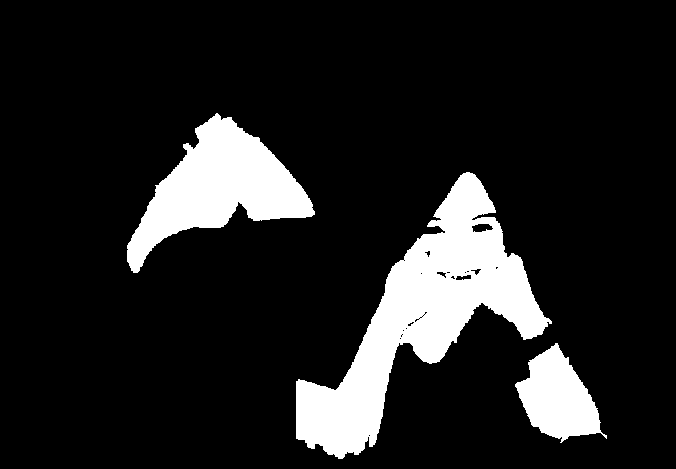

In [33]:
label_ = np.where(label==1,255,0).astype(np.uint8)
Image.fromarray(label_)

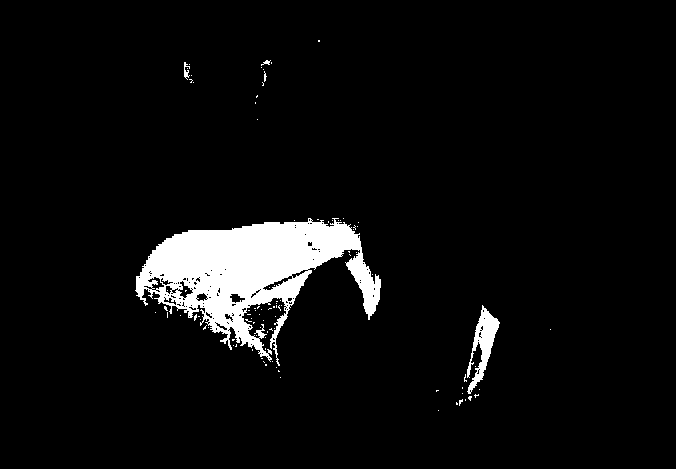

In [34]:
pred_label_ = np.where(pred_label==1,255,0).astype(np.uint8)
Image.fromarray(pred_label_)

In [28]:
iou = pd.DataFrame(IoUs,columns=['skin_iou'])

In [30]:
#iou.to_csv('../result/svm_skiniou_test.csv', header=True, index=False)

In [31]:
iou.describe()

,skin_iou
count,800.000000
mean,0.000294
std,0.003785
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.079443


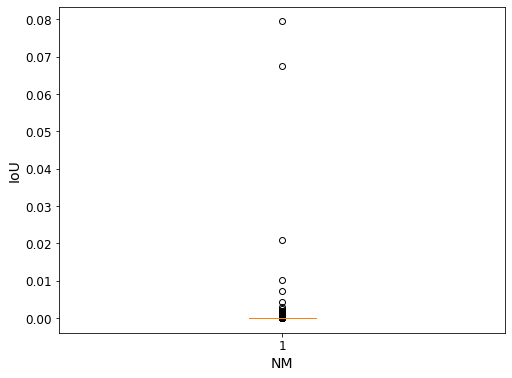

In [32]:
plt.figure(figsize=(8,6))
plt.boxplot(iou['skin_iou'])

plt.xlabel('NM')
plt.ylabel('IoU')
#plt.savefig(r'../results/naive_iou_boxplot.png',dpi=300,bbox_inches = 'tight')
plt.show()